In [7]:
#import libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

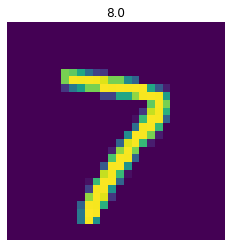

In [10]:
#prepare Dataset
#load data
train = pd.read_csv("train.csv", dtype = np.float32) # kaggle Digit Recognizer

#split data info features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 #normalization

#train test split. Size of train data is %80 and size of test data %20
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

#create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first 
#we create tensor,  then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

#create feature and targets tensor for test set
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

#batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

#pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest, targetsTest)

#data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

#visualize one of the images in data set
plt.imshow(features_numpy[321].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[321]))
plt.savefig("graph.png")
plt.show()

In [21]:
# Create ANN Model
class ANNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        
        #linear function 1: 784 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        #non-linearity 1
        self.relu1 = nn.ReLU()
        
        #linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        #non-linearity 2
        self.tanh2 = nn.Tanh()
        
        #linear function 3: 150 --> 150
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        #non-linearity 3
        self.elu3 = nn.ELU()
        
        #linear function 4 (readout): 150 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        #linear function 1
        out = self.fc1(x)
        #non-linearity 1
        out = self.relu1(out)
        
        #linear function 2
        out = self.fc2(out)
        #non-linearity 2
        out = self.tanh2(out)
        
        #linear function 2
        out = self.fc3(out)
        #non-linearity 2
        out = self.elu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out

# instantiate ANN
input_dim = 28*28
hidden_dim = 150 # hidden layer dim is one of the hyper parameter and it should be chosen and tuned. For now 150 
output_dim = 10

#create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)

#cross Entropy Loss 
error = nn.CrossEntropyLoss()

#SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [22]:
# ANN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        #clear gradients
        optimizer.zero_grad()
        
        #forward propagation
        outputs = model(train)
        
        #calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        #calculating gradients
        loss.backward()
        
        #update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            #calculate accuracy         
            correct = 0
            total = 0
            #predict test dataset
            for images, labels in test_loader:

                test = Variable(images.view(-1, 28*28))
                
                #forward propagation
                outputs = model(test)
                
                #get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                #total number of labels
                total += len(labels)

                #total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            #store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            #print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.7793295383453369  Accuracy: 80.01190185546875 %
Iteration: 1000  Loss: 0.47108012437820435  Accuracy: 87.45237731933594 %
Iteration: 1500  Loss: 0.2312970757484436  Accuracy: 89.5 %
Iteration: 2000  Loss: 0.2847205400466919  Accuracy: 90.64286041259766 %
Iteration: 2500  Loss: 0.29344698786735535  Accuracy: 91.85713958740234 %
Iteration: 3000  Loss: 0.12094923853874207  Accuracy: 92.44047546386719 %
Iteration: 3500  Loss: 0.22722311317920685  Accuracy: 93.42857360839844 %
Iteration: 4000  Loss: 0.06520304828882217  Accuracy: 93.94047546386719 %
Iteration: 4500  Loss: 0.28087037801742554  Accuracy: 94.4047622680664 %
Iteration: 5000  Loss: 0.10802656412124634  Accuracy: 94.85713958740234 %
Iteration: 5500  Loss: 0.20052045583724976  Accuracy: 94.9047622680664 %
Iteration: 6000  Loss: 0.1824733316898346  Accuracy: 95.22618865966797 %
Iteration: 6500  Loss: 0.09983617812395096  Accuracy: 95.45237731933594 %
Iteration: 7000  Loss: 0.10826435685157776  Accuracy: 95.9

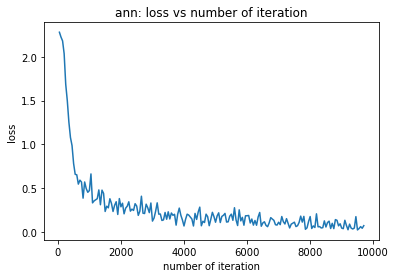

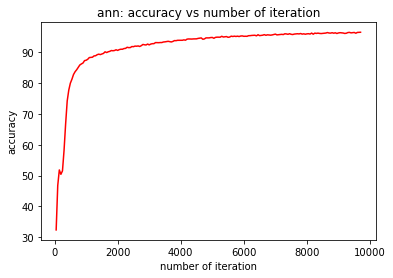

In [23]:
#visualization loss
plt.plot(iteration_list, loss_list)
plt.xlabel("number of iteration")
plt.ylabel("loss")
plt.title("ann: loss vs number of iteration")
plt.show()

#visualization accuracy
plt.plot(iteration_list, accuracy_list, color = "red")
plt.xlabel("number of iteration")
plt.ylabel("accuracy")
plt.title("ann: accuracy vs number of iteration")
plt.show()